# Phenotyping Seed hull color

### Read library

In [4]:
import PIL
from PIL import Image
import cv2
import sklearn
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import glob
from tqdm import tqdm

from sklearn.decomposition import PCA
import pandas as pd
from colormath.color_objects import XYZColor, sRGBColor
from colormath.color_conversions import convert_color

%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

matplotlib.rcParams['font.family'] = "Arial"

### Clustering function

In [5]:
# clustering colors using kmeans 
def cluster_color(img_path):
#     print(img_path)
    upstate = cv2.imread(img_path)

    upstate_hsv = cv2.cvtColor(upstate, cv2.COLOR_BGR2HSV)

    blue_min = np.array([30, 0, 25], np.uint8)
    blue_max = np.array([255, 255, 255], np.uint8)

    # get mask of pixels that are in blue range
    mask_inverse = cv2.inRange(upstate_hsv, blue_min, blue_max)

    # inverse mask to get parts that are not blue
    mask = cv2.bitwise_not(mask_inverse)

    # convert single channel mask back into 3 channels
    mask_rgb = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)

    # perform bitwise and on mask to obtain cut-out image that is not blue
    masked_upstate = cv2.bitwise_and(upstate, mask_rgb)

    # replace the cut-out parts with white
    masked_replace_white = cv2.addWeighted(masked_upstate, 1, \
                                           cv2.cvtColor(mask_inverse, cv2.COLOR_GRAY2RGB), 1, 0)
    fixed_img = cv2.cvtColor(masked_replace_white, cv2.COLOR_BGR2RGB)
    
    # clustering
    cv2_img = cv2.resize(fixed_img, (331, 468))
    cv2_img = cv2_img.reshape((cv2_img.shape[0] * cv2_img.shape[1], 3))
    cluster = KMeans(n_clusters=2)
    cluster.fit(X=cv2_img)
    KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
        n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
        random_state=None, tol=0.0001, verbose=0)
    return img_path, cluster.cluster_centers_

### extract clustering RGB values from image 

In [6]:
images = glob.glob('/Users/toshiyuki/Desktop/N09/NAM09/*.jpg')

image_labels = []
image_rgb = []
for i in tqdm(images):
    img_path, cluster = cluster_color(i)
    image_labels.append("N09_{}".format(img_path[38:41]))
    if sum(cluster[0]) > sum(cluster[1]):
        image_rgb.append(cluster[1])
    else:
        image_rgb.append(cluster[0])

100%|██████████| 235/235 [04:38<00:00,  1.18s/it]


### Change RGB value to CIE color space. And extract CIE_Y value as phenotypic value.

In [7]:
CIE_y = []
for i in image_rgb:
    rgb = sRGBColor(i[0],i[1],i[2])
    xyz = convert_color(rgb, XYZColor)
    CIE_y.append(xyz.get_value_tuple()[1])

color_values = CIE_y

color_df = pd.DataFrame(color_values, index=image_labels)
color_df.columns = ["color"]
# color_df.to_csv("original_data/grain_color_CIE.csv")
color_df.head()

,color
N09_190,188805.105475
N09_022,130218.408180
N09_242,180827.683445
N09_145,151323.422805
N09_063,186829.081043


### For parent lines

In [9]:
## KALUHEENATI & Hitomebore
parent_images = glob.glob('/Users/toshiyuki/Desktop/N09/NAM09/KALUHEENATI_Hitome_img/*.jpg')

parent_image_labels = ["Hitomebore", "KALUHEENATI"]
parent_image_rgb = []
for i in parent_images:
    parent_img_path, cluster = cluster_color(i)
    if sum(cluster[0]) > sum(cluster[1]):
        parent_image_rgb.append(cluster[1])
    else:
        parent_image_rgb.append(cluster[0])
        
parent_CIE_y = []
for i in parent_image_rgb:
    rgb = sRGBColor(i[0],i[1],i[2])
    xyz = convert_color(rgb, XYZColor)
    parent_CIE_y.append(xyz.get_value_tuple()[1])

parent_color_values = parent_CIE_y

parent_color_df = pd.DataFrame(parent_color_values, index=parent_image_labels)
parent_color_df.columns = ["color"]
parent_color_df

,color
Hitomebore,194859.256216
KALUHEENATI,58105.372219


### Visualize seed hull color distribution

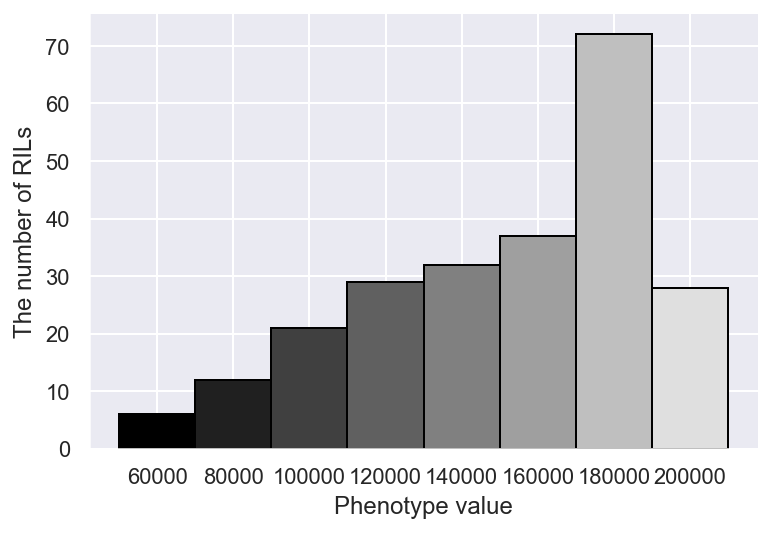

In [19]:
sns.set()

plt.rcParams["font.size"] = 14
color = pd.read_csv("../data/grain_color_CIE.csv")
color.columns = ["line", "phenotype value"]
plt.figure(figsize=(6,4))
n, bins, patches = plt.hist(color["phenotype value"], bins=[50000,70000,90000,110000,130000,150000,170000,190000,210000],edgecolor = 'black')
for i in range(8):
    patches[i].set_facecolor((i/8, i/8, i/8))
plt.xlabel("Phenotype value")
plt.ylabel("The number of RILs")
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.show()

### Visualize SPAD value distribution

/usr/local/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


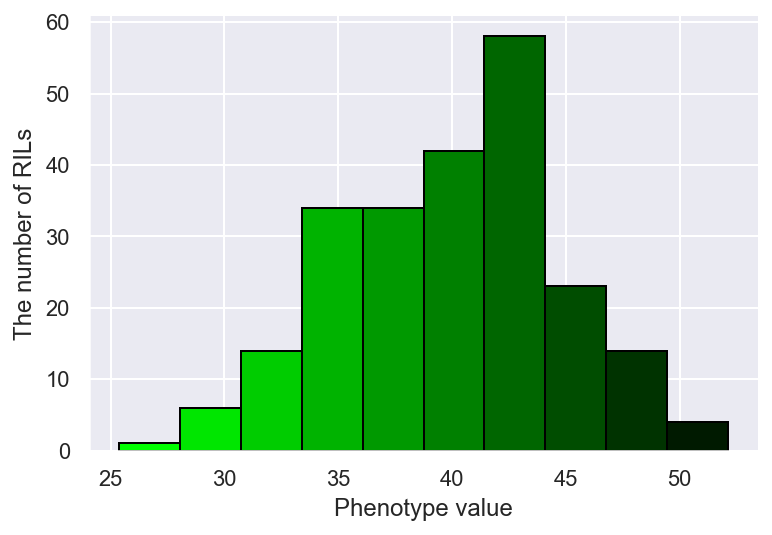

In [2]:
sns.set()

plt.rcParams["font.size"] = 14
color = pd.read_csv("../data/other_phenotype/origin_SPAD.csv")
color.columns = ["line", "phenotype value"]
plt.figure(figsize=(6,4))
# sns.distplot(color["phenotype value"], kde=False, hist=True)
n, bins, patches = plt.hist(color["phenotype value"],edgecolor = 'black')
for i in range(10):
    patches[i].set_facecolor((0, (10-i)/10, 0))
plt.xlabel("Phenotype value")
plt.ylabel("The number of RILs")
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.show()